In [1]:
import collections
import logging
import os
import pathlib
import re
import string
import sys
import time

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
import tensorflow as tf
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import collections
import re
import numpy as np
import os
import time
import json
import glob
from PIL import Image
import pickle
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Implementation

I used a small ResNet model to extract the visual feature and used the Transformer decoder to generate the output text sequence. In this Lab, the testing accuracy is about 97%.

## Dataset preprocessing

In [2]:
f = open('/home/haowei/words_captcha/spec_train_val.txt')

image_path_to_caption = {}

cnt = 0

for val in f.readlines():
    cnt += 1
    st = val.split(' ')[1].replace('\n', '')
    st = " ".join(st)
    caption = f"<start> {st} <end>"
    image_path = '/home/haowei/words_captcha/' + '%s.png' % (val.split(' ')[0])
    image_path_to_caption[image_path] = caption
print(cnt)
f.close()

image_paths = list(image_path_to_caption.keys())
train_image_paths = image_paths

print(len(image_paths))



train_captions = []
img_name_vector = []

for image_path in train_image_paths:
    caption_list = image_path_to_caption[image_path]
    train_captions.append(caption_list)
    img_name_vector.extend([image_path])
    


120000
120000


In [3]:
img_name_vector_val = []
cap = []
for file in glob.glob("/home/haowei/words_captcha/*.png"):
    if file not in img_name_vector:
        img_name_vector_val.append(file)
        cap.append(file.replace('/home/haowei/words_captcha/','').replace('.png',''))

In [4]:
print(cap)

['a129757', 'a126443', 'a125586', 'a126470', 'a128603', 'a128259', 'a133614', 'a124387', 'a139260', 'a122897', 'a130682', 'a123414', 'a139429', 'a131711', 'a137830', 'a131496', 'a137817', 'a123125', 'a121505', 'a122583', 'a137743', 'a122423', 'a123366', 'a138642', 'a122162', 'a124885', 'a129679', 'a125482', 'a126438', 'a127727', 'a128248', 'a125651', 'a122883', 'a126872', 'a133245', 'a137303', 'a138296', 'a131312', 'a125611', 'a137532', 'a137422', 'a138083', 'a128045', 'a122884', 'a129423', 'a132570', 'a131412', 'a123302', 'a136036', 'a132045', 'a124909', 'a124466', 'a137497', 'a133876', 'a125798', 'a136215', 'a125027', 'a121018', 'a128198', 'a127949', 'a120449', 'a125979', 'a137140', 'a130568', 'a122950', 'a133895', 'a123605', 'a127145', 'a122476', 'a139222', 'a138346', 'a120075', 'a126632', 'a121674', 'a129254', 'a124664', 'a139840', 'a124683', 'a134208', 'a125780', 'a124964', 'a129992', 'a132438', 'a124501', 'a126221', 'a131875', 'a135620', 'a125234', 'a136948', 'a122697', 'a133997'

In [5]:
top_k = 30
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(train_captions)

tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'
train_seqs = tokenizer.texts_to_sequences(train_captions)

cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

In [62]:
BUFFER_SIZE = 2000
BATCH_SIZE = 64

def mapping(image_path, train_captions):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.resize(img, (128, 128))
    img = img / 255.0 - 0.5
    train_captions = tf.dtypes.cast(train_captions, tf.float32)
    return img, train_captions


def mapping_val(image_path, cap):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.resize(img, (128, 128))
    img = img / 255.0 - 0.5
    return img, cap


img_train = img_name_vector[0:100000]
cap_train = cap_vector[0:100000]
img_test = img_name_vector[100001:]
cap_test = cap_vector[100001:]

dataset_train = tf.data.Dataset.from_tensor_slices((img_name_vector, cap_vector)).map(mapping)
dataset_test = tf.data.Dataset.from_tensor_slices((img_test, cap_test)).map(mapping)
dataset_val = tf.data.Dataset.from_tensor_slices((img_name_vector_val,cap)).map(mapping_val)


dataset_train = dataset_train.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset_train = dataset_train.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

dataset_test = dataset_test.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset_test = dataset_test.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

dataset_val = dataset_val.batch(100)
dataset_val = dataset_val.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)




### Sample from the training set

Every captcha is start from a <start> token and end with an <end> token. Moreover, I padded every sequence to a length of 7(the max length in training set.)

['<start>', 'm', 'a', 'r', 'y', '<end>', '<pad>']


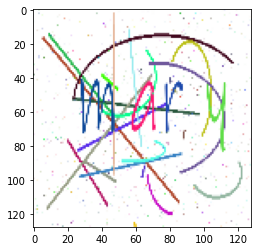

In [7]:
for x, y in dataset_train:
    result = []
    token = y.numpy()[1]
    img_ = x[1].numpy()
    for j in token:
        result.append(tokenizer.index_word[j])
    plt.imshow(img_+ 0.5)
    print(result)
    break

In [8]:
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates

In [9]:
def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)

    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)

(1, 2048, 512)


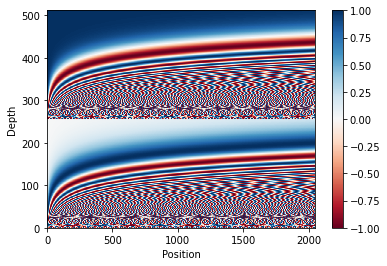

In [10]:
n, d = 2048, 512
pos_encoding = positional_encoding(n, d)
print(pos_encoding.shape)
pos_encoding = pos_encoding[0]

# Juggle the dimensions for the plot
pos_encoding = tf.reshape(pos_encoding, (n, d//2, 2))
pos_encoding = tf.transpose(pos_encoding, (2, 1, 0))
pos_encoding = tf.reshape(pos_encoding, (d, n))

plt.pcolormesh(pos_encoding, cmap='RdBu')
plt.ylabel('Depth')
plt.xlabel('Position')
plt.colorbar()
plt.show()

## Masking

Mask all the pad tokens in the batch of sequence. It ensures that the model does not treat padding as the input. The mask indicates where pad value `0` is present: it outputs a `1` at those locations, and a `0` otherwise.

In [11]:
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)

    # add extra dimensions to add the padding
    # to the attention logits.
    return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

The look-ahead mask is used to mask the future tokens in a sequence. In other words, the mask indicates which entries should not be used.

This means that to predict the third word, only the first and second word will be used. Similarly to predict the fourth word, only the first, second and the third word will be used and so on.

In [12]:
def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask  # (seq_len, seq_len)

## Scaled dot product attention

<img src="https://www.tensorflow.org/images/tutorials/transformer/scaled_attention.png" width="500" alt="scaled_dot_product_attention">

The attention function used by the transformer takes three inputs: Q (query), K (key), V (value). The equation used to calculate the attention weights is:

$$\Large{Attention(Q, K, V) = softmax_k\left(\frac{QK^T}{\sqrt{d_k}}\right) V} $$

The dot-product attention is scaled by a factor of square root of the depth. This is done because for large values of depth, the dot product grows large in magnitude pushing the softmax function where it has small gradients resulting in a very hard softmax. 

For example, consider that `Q` and `K` have a mean of 0 and variance of 1. Their matrix multiplication will have a mean of 0 and variance of `dk`. So the *square root of `dk`* is used for scaling, so you get a consistent variance regardless of the value of `dk`. If the variance is too low the output may be too flat to optimize effectively. If the variance is too high the softmax may saturate at initilization making it dificult to learn. 

The mask is multiplied with -1e9 (close to negative infinity). This is done because the mask is summed with the scaled matrix multiplication of Q and K and is applied immediately before a softmax. The goal is to zero out these cells, and large negative inputs to softmax are near zero in the output.

In [13]:
def scaled_dot_product_attention(q, k, v, mask):
    """Calculate the attention weights.
    q, k, v must have matching leading dimensions.
    k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
    The mask has different shapes depending on its type(padding or look ahead)
    but it must be broadcastable for addition.

    Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable
          to (..., seq_len_q, seq_len_k). Defaults to None.

    Returns:
    output, attention_weights
    """

    matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)

    # scale matmul_qk
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    # add the mask to the scaled tensor.
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)

    # softmax is normalized on the last axis (seq_len_k) so that the scores
    # add up to 1.
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

    output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

    return output, attention_weights

As the softmax normalization is done on K, its values decide the amount of importance given to Q.

The output represents the multiplication of the attention weights and the V (value) vector. This ensures that the words you want to focus on are kept as-is and the irrelevant words are flushed out.

## Multi-head attention

<img src="https://www.tensorflow.org/images/tutorials/transformer/multi_head_attention.png" width="500" alt="multi-head attention">


Multi-head attention consists of four parts:
*    Linear layers and split into heads.
*    Scaled dot-product attention.
*    Concatenation of heads.
*    Final linear layer.

Each multi-head attention block gets three inputs; Q (query), K (key), V (value). These are put through linear (Dense) layers and split up into multiple heads. 

The `scaled_dot_product_attention` defined above is applied to each head (broadcasted for efficiency). An appropriate mask must be used in the attention step.  The attention output for each head is then concatenated (using `tf.transpose`, and `tf.reshape`) and put through a final `Dense` layer.

Instead of one single attention head, Q, K, and V are split into multiple heads because it allows the model to jointly attend to information at different positions from different representational spaces. After the split each head has a reduced dimensionality, so the total computation cost is the same as a single head attention with full dimensionality.

In [14]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)

        self.dense = tf.keras.layers.Dense(d_model)

    def split_heads(self, x, batch_size):
        """Split the last dimension into (num_heads, depth).
        Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
        """
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]

        q = self.wq(q)  # (batch_size, seq_len, d_model)
        k = self.wk(k)  # (batch_size, seq_len, d_model)
        v = self.wv(v)  # (batch_size, seq_len, d_model)

        q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
        v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)
        


        # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
        # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
        scaled_attention, attention_weights = scaled_dot_product_attention(
            q, k, v, mask)
        


        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)


        concat_attention = tf.reshape(scaled_attention,
                                      (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

        output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)


        return output, attention_weights

In [15]:
temp_mha = MultiHeadAttention(d_model=512, num_heads=8)
y = tf.random.uniform((1, 60, 512))  # (batch_size, encoder_sequence, d_model)
out, attn = temp_mha(y, k=y, q=y, mask=None)
out.shape, attn.shape

(TensorShape([1, 60, 512]), TensorShape([1, 8, 60, 60]))

Create a `MultiHeadAttention` layer to try out. At each location in the sequence, `y`, the `MultiHeadAttention` runs all 8 attention heads across all other locations in the sequence, returning a new vector of the same length at each location.

## Point wise feed forward network

Point wise feed forward network consists of two fully-connected layers with a ReLU activation in between.

In [16]:
def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
    ])

## Encoder and decoder

<img src="https://www.tensorflow.org/images/tutorials/transformer/transformer.png" width="600" alt="transformer">

In [17]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()

        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)

        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)

    def call(self, x, enc_output, training,
           look_ahead_mask, padding_mask):
        # enc_output.shape == (batch_size, input_seq_len, d_model)

        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)
        
        attn2, attn_weights_block2 = self.mha2(
            enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)

        ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)

        return out3, attn_weights_block1, attn_weights_block2

### Encoder

The `Encoder` consists of ResNet

In [18]:
class Residual(tf.keras.Model):
    """The Residual block of ResNet."""
    def __init__(self, num_channels, use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = tf.keras.layers.Conv2D(num_channels, padding='same',
                                            kernel_size=3, strides=strides)
        self.conv2 = tf.keras.layers.Conv2D(num_channels, kernel_size=3,
                                            padding='same')
        self.conv3 = None
        if use_1x1conv:
            self.conv3 = tf.keras.layers.Conv2D(num_channels, kernel_size=1,
                                                strides=strides)
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.bn2 = tf.keras.layers.BatchNormalization()

    def call(self, X):
        Y = tf.keras.activations.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3 is not None:
            X = self.conv3(X)
        Y += X
        return tf.keras.activations.relu(Y)

In [19]:
class ResnetBlock(tf.keras.layers.Layer):
    def __init__(self, num_channels, num_residuals, first_block=False,
                 **kwargs):
        super(ResnetBlock, self).__init__(**kwargs)
        self.residual_layers = []
        for i in range(num_residuals):
            if i == 0 and not first_block:
                self.residual_layers.append(
                    Residual(num_channels, use_1x1conv=True, strides=2))
            else:
                self.residual_layers.append(Residual(num_channels))

    def call(self, X):
        for layer in self.residual_layers.layers:
            X = layer(X)
        return X

In [20]:
class Encoder(tf.keras.layers.Layer): # ResNet
    def __init__(self):
        super(Encoder, self).__init__()
        self.cov1 = tf.keras.layers.Conv2D(64, kernel_size=7, strides=2, padding='same')
        self.batch_norm =  tf.keras.layers.BatchNormalization()
        self.max_pool = tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same')
        self.res_1 = ResnetBlock(64, 2, first_block=True)
        self.res_2 = ResnetBlock(128, 2)
        self.batch_norm_1 =  tf.keras.layers.BatchNormalization()
        self.res_3 = ResnetBlock(128, 2)
        self.batch_norm_2 =  tf.keras.layers.BatchNormalization()
        self.res_4 = ResnetBlock(128, 2)
        self.batch_norm_3 =  tf.keras.layers.BatchNormalization()
        self.glob_pool =  tf.keras.layers.GlobalAvgPool2D()
        self.fc = tf.keras.layers.Dense(256)
        
    def call(self, x):
        x = self.cov1(x)
        x = self.batch_norm(x)
        x = tf.nn.relu(x)
        x = self.max_pool(x)
        x = self.res_1(x)
        x = self.batch_norm_1(x)
        x = self.res_2(x)
        x = self.batch_norm_2(x)
        x = self.res_4(x)
        x = self.batch_norm_3(x)
        x = self.glob_pool(x)
        x = self.fc(x)

        

        return x  # (batch_size, input_seq_len, d_model)

In [21]:
temp_embedding = tf.random.uniform((64, 141), dtype=tf.float64, minval=0, maxval=28)
temp_img = tf.random.uniform((64, 128, 128), dtype=tf.float64, minval=-1, maxval=1)


sample_encoder = Encoder()


temp_input = tf.random.uniform((64, 128, 128, 3), dtype=tf.float64, minval=-1, maxval=1)

sample_encoder_output = sample_encoder(temp_input)

sample_encoder_output.shape



TensorShape([64, 256])

### Decoder

 The `Decoder` consists of:
1.   Output Embedding
2.   Positional Encoding
3.   N decoder layers

The target is put through an embedding which is summed with the positional encoding. The output of this summation is the input to the decoder layers. The output of the decoder is the input to the final linear layer.

In [22]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,
               maximum_position_encoding, rate=0.1):
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)

        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate)
                           for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x, enc_output, training,
               look_ahead_mask, padding_mask):

        seq_len = tf.shape(x)[1]
        attention_weights = {}

        x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]
        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                                 look_ahead_mask, padding_mask)

            attention_weights[f'decoder_layer{i+1}_block1'] = block1
            attention_weights[f'decoder_layer{i+1}_block2'] = block2

    # x.shape == (batch_size, target_seq_len, d_model)
        return x, attention_weights

In [23]:


sample_decoder = Decoder(num_layers=2, d_model=512, num_heads=8,
                         dff=2048, target_vocab_size=29,
                         maximum_position_encoding=141)
temp_input = tf.random.uniform((1, 7), dtype=tf.float64, minval=0, maxval=28)
sample_encoder_output = tf.random.uniform((1, 128), dtype=tf.float64, minval=0, maxval=28)

output, attn = sample_decoder(temp_input,
                              enc_output=sample_encoder_output,
                              training=False,
                              look_ahead_mask=None,
                              padding_mask=None)




## Create the Transformer

Transformer consists of the encoder, decoder and a final linear layer. The output of the decoder is the input to the linear layer and its output is returned.

In [24]:
class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
               target_vocab_size, pe_input, pe_target, rate=0.1):
        super(Transformer, self).__init__()
        
        self.encoder = Encoder()

        self.decoder = Decoder(num_layers, d_model, num_heads, dff,
                               target_vocab_size, pe_target, rate)

        self.final_layer = tf.keras.layers.Dense(target_vocab_size)

    def call(self, x, tar, training, enc_padding_mask, look_ahead_mask, dec_padding_mask):

        x = self.encoder(x)
    
        dec_output, attention_weights = self.decoder(
            tar, x, training, look_ahead_mask, dec_padding_mask)

        final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)

        return final_output, attention_weights

In [25]:
sample_transformer = Transformer(
    num_layers=4, d_model=128, num_heads=4, dff=128,
    input_vocab_size=29, target_vocab_size=29,
    pe_input=10000, pe_target=6000)


temp_input = tf.random.uniform((64, 128, 128, 3), dtype=tf.float64, minval=-1, maxval=1)
temp_target = tf.random.uniform((64, 7), dtype=tf.int32, minval=0, maxval=28)

fn_out, _ = sample_transformer(temp_input, temp_target, training=False,enc_padding_mask=None,look_ahead_mask=None,dec_padding_mask=None)

fn_out.shape  # (batch_size, tar_seq_len, target_vocab_size)

TensorShape([64, 7, 29])

## Set hyperparameters

To keep this example small and relatively fast, the values for *num_layers, d_model, and dff* have been reduced. 

The values used in the base model of transformer were; *num_layers=6*, *d_model = 512*, *dff = 2048*. See the [paper](https://arxiv.org/abs/1706.03762) for all the other versions of the transformer.

Note: By changing the values below, you can get the model that achieved state of the art on many tasks.

In [26]:
num_layers = 4
d_model = 128
dff = 128
num_heads = 4
dropout_rate = 0.1

## Optimizer

Use the Adam optimizer with a custom learning rate scheduler according to the formula in the [paper](https://arxiv.org/abs/1706.03762).

$$\Large{lrate = d_{model}^{-0.5} * \min(step{\_}num^{-0.5}, step{\_}num \cdot warmup{\_}steps^{-1.5})}$$


In [27]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [28]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

## Loss and metrics

Since the target sequences are padded, it is important to apply a padding mask when calculating the loss.

In [29]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

In [88]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)


def accuracy_function(real, pred):
    not_paddings = (real != 0)
    logics = (real == tf.dtypes.cast(pred, tf.float32))
    logics = logics & not_paddings
    summation = tf.reduce_sum(tf.cast(logics, tf.float32))
    total = tf.reduce_sum(tf.cast(not_paddings, tf.float32))
    return summation/total

In [89]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

val_loss = tf.keras.metrics.Mean(name='val_loss')
val_accuracy = tf.keras.metrics.Mean(name='val_accuracy')

## Training and checkpointing

In [90]:
transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=1000,
    target_vocab_size=1000,
    pe_input=1000,
    pe_target=1000,
    rate=dropout_rate)

In [91]:
def create_masks(inp, tar):
    # Encoder padding mask
    enc_padding_mask = create_padding_mask(inp)

    # Used in the 2nd attention block in the decoder.
    # This padding mask is used to mask the encoder outputs.
    dec_padding_mask = create_padding_mask(inp)

    # Used in the 1st attention block in the decoder.
    # It is used to pad and mask future tokens in the input received by
    # the decoder.
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

    return enc_padding_mask, combined_mask, dec_padding_mask


temp_embedding = tf.random.uniform((64, 141), dtype=tf.float64, minval=0, maxval=28)
temp_img = tf.random.uniform((64, 128), dtype=tf.float64, minval=-1, maxval=1)

enc_padding_mask, combined_mask, dec_padding_mask = create_masks(temp_img, temp_embedding)

In [92]:
EPOCHS = 150

In [93]:
def train_step(inp, tar):
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]

    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)

    with tf.GradientTape() as tape:
        predictions, _ = transformer(inp, tar_inp,
                                     True,
                                     None,
                                     combined_mask,
                                     None)
        loss = loss_function(tar_real, predictions)

    gradients = tape.gradient(loss, transformer.trainable_variables)
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
    prediction = tf.argmax(predictions, axis=-1)

    train_loss(loss)
    train_accuracy(accuracy_function(tar_real, prediction))

In [94]:
def val_step(inp, tar):
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]

    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)

    predictions, _ = transformer(inp, tar_inp,
                                 True,
                                 None,
                                 combined_mask,
                                 None)
    loss = loss_function(tar_real, predictions)

    prediction = tf.argmax(predictions, axis=-1)

    val_loss(loss)
    val_accuracy(accuracy_function(tar_real, prediction))

In [95]:
checkpoint_path = "./checkpoints/Lab13-2_107062132_2"

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print('Latest checkpoint restored!!')

Latest checkpoint restored!!


In [ ]:
for epoch in range(EPOCHS):
    start = time.time()
    train_loss.reset_states()
    train_accuracy.reset_states()
    val_loss.reset_states()
    val_accuracy.reset_states()
    ckpt_save_path = ckpt_manager.save()
    print(f'Saving checkpoint for epoch {epoch+1} at {ckpt_save_path}')

  # inp -> img, tar -> captioning
    for (batch, (inp, tar)) in enumerate(dataset_train):
        train_step(inp, tar)

        if batch % 50 == 0:
            print(f'Epoch {epoch + 1} Batch {batch} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')
    
    for (batch, (inp, tar)) in enumerate(dataset_test):
        val_step(inp, tar)

        if batch % 50 == 0:
            print(f'Epoch {epoch + 1} Batch {batch} Loss {val_loss.result():.4f} Accuracy {val_accuracy.result():.4f}')

    print(f'Epoch {epoch + 1} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')

    print(f'Time taken for 1 epoch: {time.time() - start:.2f} secs\n')

Saving checkpoint for epoch 1 at ./checkpoints/Lab13-2_107062132_2/ckpt-3
Epoch 1 Batch 0 Loss 7.1180 Accuracy 0.0000
Epoch 1 Batch 50 Loss 3.3229 Accuracy 0.2205
Epoch 1 Batch 100 Loss 2.9578 Accuracy 0.2403
Epoch 1 Batch 150 Loss 2.7991 Accuracy 0.2540
Epoch 1 Batch 200 Loss 2.6877 Accuracy 0.2674
Epoch 1 Batch 250 Loss 2.5894 Accuracy 0.2813
Epoch 1 Batch 300 Loss 2.5044 Accuracy 0.2938
Epoch 1 Batch 350 Loss 2.4301 Accuracy 0.3061
Epoch 1 Batch 400 Loss 2.3652 Accuracy 0.3177
Epoch 1 Batch 450 Loss 2.3057 Accuracy 0.3290
Epoch 1 Batch 500 Loss 2.2477 Accuracy 0.3407
Epoch 1 Batch 550 Loss 2.1922 Accuracy 0.3528
Epoch 1 Batch 600 Loss 2.1397 Accuracy 0.3652
Epoch 1 Batch 650 Loss 2.0888 Accuracy 0.3776
Epoch 1 Batch 700 Loss 2.0388 Accuracy 0.3903
Epoch 1 Batch 750 Loss 1.9898 Accuracy 0.4029
Epoch 1 Batch 800 Loss 1.9418 Accuracy 0.4160
Epoch 1 Batch 850 Loss 1.8950 Accuracy 0.4287
Epoch 1 Batch 900 Loss 1.8504 Accuracy 0.4411
Epoch 1 Batch 950 Loss 1.8078 Accuracy 0.4532
Epoch 1 B

Epoch 4 Batch 1550 Loss 0.0839 Accuracy 0.9772
Epoch 4 Batch 1600 Loss 0.0835 Accuracy 0.9773
Epoch 4 Batch 1650 Loss 0.0831 Accuracy 0.9774
Epoch 4 Batch 1700 Loss 0.0827 Accuracy 0.9775
Epoch 4 Batch 1750 Loss 0.0822 Accuracy 0.9777
Epoch 4 Batch 1800 Loss 0.0818 Accuracy 0.9778
Epoch 4 Batch 1850 Loss 0.0812 Accuracy 0.9779
Epoch 4 Batch 0 Loss 0.0715 Accuracy 0.9746
Epoch 4 Batch 50 Loss 0.0548 Accuracy 0.9850
Epoch 4 Batch 100 Loss 0.0516 Accuracy 0.9857
Epoch 4 Batch 150 Loss 0.0525 Accuracy 0.9855
Epoch 4 Batch 200 Loss 0.0507 Accuracy 0.9859
Epoch 4 Batch 250 Loss 0.0491 Accuracy 0.9864
Epoch 4 Batch 300 Loss 0.0473 Accuracy 0.9868
Epoch 4 Loss 0.0811 Accuracy 0.9780
Time taken for 1 epoch: 276.53 secs

Saving checkpoint for epoch 5 at ./checkpoints/Lab13-2_107062132_2/ckpt-7
Epoch 5 Batch 0 Loss 0.0361 Accuracy 0.9872
Epoch 5 Batch 50 Loss 0.0643 Accuracy 0.9824
Epoch 5 Batch 100 Loss 0.0658 Accuracy 0.9823
Epoch 5 Batch 150 Loss 0.0654 Accuracy 0.9824
Epoch 5 Batch 200 Loss 0

In [ ]:
def evaluate(img):
    output = tf.fill([img.shape[0], 1], tokenizer.word_index['<start>'])

    for i in range(6):
        temp_img = tf.random.uniform((img.shape[0], 128), dtype=tf.float64, minval=-1, maxval=1)

        enc_padding_mask, combined_mask, dec_padding_mask = create_masks(temp_img, output)
        
        predictions, attention_weights = transformer(img,
                                                 output,
                                                 False,
                                                 None,
                                                 combined_mask,
                                                 None)
        
        predictions = predictions[:, -1:, :] 
        predicted_id = tf.argmax(predictions.numpy(), axis=-1)
        to_append = tf.cast(predicted_id, tf.int32)
        output = tf.concat([output, to_append], axis=-1)



    return output

## Calculate the accuracy

In [97]:
def accuracy_function(real, pred):
    summation = 0
    total = 0
    real[real == 0] = 2 # remove padding, start and end tokens
    real[real == 2] = 2
    real[real == 3] = 2
    pred[pred == 0] = 2
    pred[pred == 2] = 2
    pred[pred == 3] = 2
    for idx,_ in enumerate(real):
        total += 1
        if np.array_equal(pred[idx], real[idx]):
            summation+=1
            
        
    return summation/total

In [98]:
b = 0
acc = 0
for x, y in dataset_test:
    predict = evaluate(x)
    acc += accuracy_function(np.array(predict), np.array(tf.cast(y, tf.int32)))
    b += 1
    
print("Accuracy:", acc/b)
    





Accuracy: 0.9759884185303515


In [100]:
ans = []

for idx,(x, y) in enumerate(dataset_val):
    predict = np.array(evaluate(x))
    for output in predict:
        captcha = ''
        for word in output:
            new_word = tokenizer.index_word[word]
            if new_word != '<start>' and new_word != '<end>':
                captcha += new_word
        ans.append(captcha)

In [101]:
print(len(ans))
print(len(cap))

20000
20000


# Output the result

In [102]:
file1 = open("./final_prediction.txt","w")

for captcha, name in zip(ans,cap):
    file1.writelines(name+' '+captcha+'\n')
file1.close()